# Packages


In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

random_state = 10


import warnings
warnings.filterwarnings('ignore')

# Import and understand dataset

In [2]:
train = pd.read_csv("datasets/Housing_dataset_train.csv")
test = pd.read_csv("datasets/Housing_dataset_test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [3]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [4]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [5]:
train.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [6]:
data = train.drop("price", axis=1).append(test).drop('ID', axis=1)

Removing data would result in the model working poorly because it dropped over 30% of the data after.<br/>
Hence, I decided to go with another way: <br/>
* using mean to replace null for columns with continuous data
* using U to replace null for columns with descrete data

In [7]:
# train.dropna(inplace=True)
# train.info()

data['bedroom'] = data['bedroom'].replace(np.nan, data['bedroom'].mean())
data['bathroom'] = data['bathroom'].replace(np.nan, data['bathroom'].mean())
data['parking_space'] = data['parking_space'].replace(np.nan, data['parking_space'].mean())
# data['loc'] = data['loc'].replace(np.nan, 'U')
# data['title'] = data['title'].replace(np.nan, 'U')

data = data.rename(columns={'loc': 'location'})
data.head()

,location,title,bedroom,bathroom,parking_space
0,Katsina,Semi-detached duplex,2.000000,2.0,1.000000
1,Ondo,Apartment,4.315312,2.0,4.000000
2,Ekiti,NaN,7.000000,5.0,3.157458
3,Anambra,Detached duplex,5.000000,2.0,4.000000
4,Kogi,Terrace duplex,4.315312,5.0,6.000000


In [8]:
def engineer_data(raw_data):
    # Define the ranking based on size (arranged from smallest to biggest)
    house_type_ranks = {
        'Cottage': 1,
        'Bungalow': 2,
        'Townhouse': 3,
        'Terrace duplex': 4,
        'Detached duplex': 5,
        'Semi-detached duplex': 6,
        'Flat': 7,
        'Penthouse': 8,
        'Apartment': 9,
        'Mansion': 10
    }


    # Map the house types to numerical values based on size ranking
    raw_data['title'] = raw_data['title'].map(house_type_ranks)

    # map of each state to its geo political zone
    state_to_geo_zone = {
        'Plateau': 'North Central',
        'Niger': 'North Central',
        'Nasarawa': 'North Central',
        'Kwara': 'North Central',
        'Kogi': 'North Central',
        'FCT': 'North Central',
        'Benue': 'North Central',
        'Yobe': 'North East',
        'Taraba': 'North East',
        'Gombe': 'North East',
        'Borno': 'North East',
        'Bauchi': 'North East',
        'Adamawa': 'North East',
        'Zamfara': 'North West',
        'Jigawa': 'North West',
        'Sokoto': 'North West',
        'Kebbi': 'North West',
        'Kano': 'North West',
        'Katsina': 'North West',
        'Kaduna': 'North West',
        'Abia': 'South East',
        'Imo': 'South East',
        'Enugu': 'South East',
        'Ebonyi': 'South East',
        'Anambra': 'South East',
        'Rivers': 'South South',
        'Edo': 'South South',
        'Delta': 'South South',
        'Cross River': 'South South',
        'Bayelsa': 'South South',
        'Akwa Ibom': 'South South',
        'Oyo': 'South West',
        'Ogun': 'South West',
        'Ondo': 'South West',
        'Osun': 'South West',
        'Lagos': 'South West',
        'Ekiti': 'South West',
    #     'U': 'U'
    }

    raw_data['geo_zone'] = raw_data['location'].map(state_to_geo_zone)

    
    # Calculate the frequency of each category in the 'loc' column
    # Then map the location column to the corresponding frequency
    category_frequencies = raw_data['location'].value_counts(normalize=True)
    location_frequency_mapping = category_frequencies.to_dict()
    raw_data['location'] = raw_data['location'].map(location_frequency_mapping)

    
    # Calculate the frequency of each category in the 'geo_zone' column
    # Then map the geo_zone column to the corresponding frequency
    geo_category_freq = raw_data['geo_zone'].value_counts(normalize=True)
    geo_zone_frequency_mapping = geo_category_freq.to_dict()
    raw_data['geo_zone'] = raw_data['geo_zone'].map(geo_zone_frequency_mapping)

    # Create a new column which is the bathroom to bedroom ratio
    raw_data['bath_to_bedroom_ratio'] = raw_data['bathroom'] / raw_data['bedroom']
    print(raw_data.head())
    
    return raw_data

In [9]:
train.shape[0]

14000

In [10]:
# data.describe()

Split our data into feature X and target y and remove ID as it won't contribute anything meaningful to our model

In [11]:
# X, y = train.iloc[:, 1:-1], train.iloc[:, -1]

# print(X.head())
# print(y.head())

data = engineer_data(data)

X = data[:train.shape[0]]
y = train.price

test_df = data[train.shape[0]:]

   location  title   bedroom  bathroom  parking_space  geo_zone  \
0  0.028592    6.0  2.000000       2.0       1.000000  0.197229   
1  0.028097    9.0  4.315312       2.0       4.000000  0.169297   
2  0.027822    NaN  7.000000       5.0       3.157458  0.169297   
3  0.029856    5.0  5.000000       2.0       4.000000  0.137791   
4  0.027382    4.0  4.315312       5.0       6.000000  0.166328   

   bath_to_bedroom_ratio  
0               1.000000  
1               0.463466  
2               0.714286  
3               0.400000  
4               1.158665  


In [12]:
X.shape, y.shape, test_df.shape

((14000, 7), (14000,), (6000, 7))

## Split into training and test data

In [13]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [14]:
print(len(train_X))
# print(train_y)
# print(test_X)
# print(test_y)

11200


## Model Training and Tuning to get the best parameters
I did a gridsearch to test the combination of multiple parameters(parameter tuning) and found that the model performs best when n_estimators=500 and max_depth=4


In [15]:
y_train_log = np.log1p(train_y)
y_test_log = np.log1p(test_y)

# xgb_model = XGBRegressor(seed=random_state, eval_metric=MSE, early_stopping_rounds=100, eval_set=[(train_X,y_train_log),(test_X, y_test_log)])

# clf = GridSearchCV(xgb_model, {
#     'max_depth': [2, 4, 6, 8],
#     'n_estimators': [50, 100, 200, 500, 1000],
#     'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05] }, verbose=1,
#     n_jobs=2,
#     refit='neg_root_mean_squared_error',
#     scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
# )


In [16]:
# clf.fit(train_X, train_y, eval_set=[(train_X,y_train_log),(test_X, y_test_log)])

# print(clf.best_score_)
# print(clf.best_params_)
# print(clf.cv_results_)

In [17]:
xgb_model = XGBRegressor(learning_rate=0.04,
                         max_depth=4,
                         n_estimators=500,
                         seed=random_state,
                         n_jobs=2,
                         eval_metric=MSE,
                         early_stopping_rounds=100)


In [18]:


xgb_model.fit(train_X, y_train_log, verbose=True, eval_set=[(train_X,y_train_log),(test_X, y_test_log)])

[0]	validation_0-rmse:13.41880	validation_0-mean_squared_error:180.06410	validation_1-rmse:13.42669	validation_1-mean_squared_error:180.27608
[1]	validation_0-rmse:12.88257	validation_0-mean_squared_error:165.96059	validation_1-rmse:12.89045	validation_1-mean_squared_error:166.16359
[2]	validation_0-rmse:12.36782	validation_0-mean_squared_error:152.96287	validation_1-rmse:12.37579	validation_1-mean_squared_error:153.16026
[3]	validation_0-rmse:11.87364	validation_0-mean_squared_error:140.98335	validation_1-rmse:11.88160	validation_1-mean_squared_error:141.17241
[4]	validation_0-rmse:11.39926	validation_0-mean_squared_error:129.94315	validation_1-rmse:11.40731	validation_1-mean_squared_error:130.12683
[5]	validation_0-rmse:10.94385	validation_0-mean_squared_error:119.76790	validation_1-rmse:10.95187	validation_1-mean_squared_error:119.94343
[6]	validation_0-rmse:10.50666	validation_0-mean_squared_error:110.38982	validation_1-rmse:10.51460	validation_1-mean_squared_error:110.55679
[7]	va

[60]	validation_0-rmse:1.19071	validation_0-mean_squared_error:1.41779	validation_1-rmse:1.19564	validation_1-mean_squared_error:1.42955
[61]	validation_0-rmse:1.14502	validation_0-mean_squared_error:1.31107	validation_1-rmse:1.14989	validation_1-mean_squared_error:1.32226
[62]	validation_0-rmse:1.10152	validation_0-mean_squared_error:1.21335	validation_1-rmse:1.10632	validation_1-mean_squared_error:1.22395
[63]	validation_0-rmse:1.05982	validation_0-mean_squared_error:1.12322	validation_1-rmse:1.06459	validation_1-mean_squared_error:1.13335
[64]	validation_0-rmse:1.01985	validation_0-mean_squared_error:1.04010	validation_1-rmse:1.02466	validation_1-mean_squared_error:1.04993
[65]	validation_0-rmse:0.98155	validation_0-mean_squared_error:0.96344	validation_1-rmse:0.98634	validation_1-mean_squared_error:0.97287
[66]	validation_0-rmse:0.94482	validation_0-mean_squared_error:0.89268	validation_1-rmse:0.94957	validation_1-mean_squared_error:0.90169
[67]	validation_0-rmse:0.90971	validation

[120]	validation_0-rmse:0.24133	validation_0-mean_squared_error:0.05824	validation_1-rmse:0.24443	validation_1-mean_squared_error:0.05974
[121]	validation_0-rmse:0.23943	validation_0-mean_squared_error:0.05733	validation_1-rmse:0.24247	validation_1-mean_squared_error:0.05879
[122]	validation_0-rmse:0.23747	validation_0-mean_squared_error:0.05639	validation_1-rmse:0.24053	validation_1-mean_squared_error:0.05785
[123]	validation_0-rmse:0.23564	validation_0-mean_squared_error:0.05552	validation_1-rmse:0.23865	validation_1-mean_squared_error:0.05695
[124]	validation_0-rmse:0.23375	validation_0-mean_squared_error:0.05464	validation_1-rmse:0.23672	validation_1-mean_squared_error:0.05604
[125]	validation_0-rmse:0.23219	validation_0-mean_squared_error:0.05391	validation_1-rmse:0.23517	validation_1-mean_squared_error:0.05530
[126]	validation_0-rmse:0.23078	validation_0-mean_squared_error:0.05326	validation_1-rmse:0.23381	validation_1-mean_squared_error:0.05466
[127]	validation_0-rmse:0.22889	va

[180]	validation_0-rmse:0.19896	validation_0-mean_squared_error:0.03958	validation_1-rmse:0.20106	validation_1-mean_squared_error:0.04042
[181]	validation_0-rmse:0.19841	validation_0-mean_squared_error:0.03937	validation_1-rmse:0.20050	validation_1-mean_squared_error:0.04020
[182]	validation_0-rmse:0.19810	validation_0-mean_squared_error:0.03925	validation_1-rmse:0.20019	validation_1-mean_squared_error:0.04008
[183]	validation_0-rmse:0.19800	validation_0-mean_squared_error:0.03920	validation_1-rmse:0.20008	validation_1-mean_squared_error:0.04003
[184]	validation_0-rmse:0.19786	validation_0-mean_squared_error:0.03915	validation_1-rmse:0.19991	validation_1-mean_squared_error:0.03996
[185]	validation_0-rmse:0.19771	validation_0-mean_squared_error:0.03909	validation_1-rmse:0.19976	validation_1-mean_squared_error:0.03991
[186]	validation_0-rmse:0.19742	validation_0-mean_squared_error:0.03897	validation_1-rmse:0.19948	validation_1-mean_squared_error:0.03979
[187]	validation_0-rmse:0.19695	va

[240]	validation_0-rmse:0.19034	validation_0-mean_squared_error:0.03623	validation_1-rmse:0.19285	validation_1-mean_squared_error:0.03719
[241]	validation_0-rmse:0.19027	validation_0-mean_squared_error:0.03620	validation_1-rmse:0.19278	validation_1-mean_squared_error:0.03716
[242]	validation_0-rmse:0.19009	validation_0-mean_squared_error:0.03613	validation_1-rmse:0.19258	validation_1-mean_squared_error:0.03709
[243]	validation_0-rmse:0.19004	validation_0-mean_squared_error:0.03612	validation_1-rmse:0.19255	validation_1-mean_squared_error:0.03707
[244]	validation_0-rmse:0.18997	validation_0-mean_squared_error:0.03609	validation_1-rmse:0.19247	validation_1-mean_squared_error:0.03704
[245]	validation_0-rmse:0.18990	validation_0-mean_squared_error:0.03606	validation_1-rmse:0.19238	validation_1-mean_squared_error:0.03701
[246]	validation_0-rmse:0.18973	validation_0-mean_squared_error:0.03600	validation_1-rmse:0.19221	validation_1-mean_squared_error:0.03694
[247]	validation_0-rmse:0.18966	va

[300]	validation_0-rmse:0.18632	validation_0-mean_squared_error:0.03472	validation_1-rmse:0.18930	validation_1-mean_squared_error:0.03583
[301]	validation_0-rmse:0.18629	validation_0-mean_squared_error:0.03470	validation_1-rmse:0.18927	validation_1-mean_squared_error:0.03582
[302]	validation_0-rmse:0.18619	validation_0-mean_squared_error:0.03467	validation_1-rmse:0.18920	validation_1-mean_squared_error:0.03580
[303]	validation_0-rmse:0.18615	validation_0-mean_squared_error:0.03465	validation_1-rmse:0.18917	validation_1-mean_squared_error:0.03579
[304]	validation_0-rmse:0.18612	validation_0-mean_squared_error:0.03464	validation_1-rmse:0.18917	validation_1-mean_squared_error:0.03579
[305]	validation_0-rmse:0.18610	validation_0-mean_squared_error:0.03463	validation_1-rmse:0.18915	validation_1-mean_squared_error:0.03578
[306]	validation_0-rmse:0.18605	validation_0-mean_squared_error:0.03462	validation_1-rmse:0.18911	validation_1-mean_squared_error:0.03576
[307]	validation_0-rmse:0.18596	va

[360]	validation_0-rmse:0.18379	validation_0-mean_squared_error:0.03378	validation_1-rmse:0.18771	validation_1-mean_squared_error:0.03524
[361]	validation_0-rmse:0.18375	validation_0-mean_squared_error:0.03377	validation_1-rmse:0.18769	validation_1-mean_squared_error:0.03523
[362]	validation_0-rmse:0.18374	validation_0-mean_squared_error:0.03376	validation_1-rmse:0.18768	validation_1-mean_squared_error:0.03522
[363]	validation_0-rmse:0.18371	validation_0-mean_squared_error:0.03375	validation_1-rmse:0.18767	validation_1-mean_squared_error:0.03522
[364]	validation_0-rmse:0.18366	validation_0-mean_squared_error:0.03373	validation_1-rmse:0.18760	validation_1-mean_squared_error:0.03519
[365]	validation_0-rmse:0.18363	validation_0-mean_squared_error:0.03372	validation_1-rmse:0.18760	validation_1-mean_squared_error:0.03519
[366]	validation_0-rmse:0.18358	validation_0-mean_squared_error:0.03370	validation_1-rmse:0.18757	validation_1-mean_squared_error:0.03518
[367]	validation_0-rmse:0.18355	va

[420]	validation_0-rmse:0.18204	validation_0-mean_squared_error:0.03314	validation_1-rmse:0.18708	validation_1-mean_squared_error:0.03500
[421]	validation_0-rmse:0.18200	validation_0-mean_squared_error:0.03312	validation_1-rmse:0.18707	validation_1-mean_squared_error:0.03499
[422]	validation_0-rmse:0.18196	validation_0-mean_squared_error:0.03311	validation_1-rmse:0.18706	validation_1-mean_squared_error:0.03499
[423]	validation_0-rmse:0.18194	validation_0-mean_squared_error:0.03310	validation_1-rmse:0.18705	validation_1-mean_squared_error:0.03499
[424]	validation_0-rmse:0.18193	validation_0-mean_squared_error:0.03310	validation_1-rmse:0.18705	validation_1-mean_squared_error:0.03499
[425]	validation_0-rmse:0.18192	validation_0-mean_squared_error:0.03309	validation_1-rmse:0.18705	validation_1-mean_squared_error:0.03499
[426]	validation_0-rmse:0.18190	validation_0-mean_squared_error:0.03309	validation_1-rmse:0.18707	validation_1-mean_squared_error:0.03500
[427]	validation_0-rmse:0.18186	va

[480]	validation_0-rmse:0.18055	validation_0-mean_squared_error:0.03260	validation_1-rmse:0.18685	validation_1-mean_squared_error:0.03491
[481]	validation_0-rmse:0.18053	validation_0-mean_squared_error:0.03259	validation_1-rmse:0.18684	validation_1-mean_squared_error:0.03491
[482]	validation_0-rmse:0.18052	validation_0-mean_squared_error:0.03259	validation_1-rmse:0.18686	validation_1-mean_squared_error:0.03492
[483]	validation_0-rmse:0.18048	validation_0-mean_squared_error:0.03257	validation_1-rmse:0.18685	validation_1-mean_squared_error:0.03491
[484]	validation_0-rmse:0.18044	validation_0-mean_squared_error:0.03256	validation_1-rmse:0.18684	validation_1-mean_squared_error:0.03491
[485]	validation_0-rmse:0.18040	validation_0-mean_squared_error:0.03254	validation_1-rmse:0.18682	validation_1-mean_squared_error:0.03490
[486]	validation_0-rmse:0.18038	validation_0-mean_squared_error:0.03254	validation_1-rmse:0.18683	validation_1-mean_squared_error:0.03491
[487]	validation_0-rmse:0.18036	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7f85d932baf0>,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=2,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

## Test our model with the test set to measure how well it performs
I used Mean absolute percentage error and Root Mean Square Error as the metrics

In [19]:
y_pred = xgb_model.predict(test_X)

In [20]:
# print(test_y[:100] - y_pred[:100])
# print(y_pred[:50])
# print(test_y[:50])

In [21]:
rmse = np.sqrt(MSE(test_y, np.expm1(y_pred)))

# Mean absolute percentage error
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [22]:
print("Root Mean Square Error is: ", rmse)
print("Mean absolute percentage error is : ", MAPE(test_y, np.expm1(y_pred)))

Root Mean Square Error is:  568341.699273767
Mean absolute percentage error is :  11.522882755332448


In [23]:
xgb_model.feature_importances_

array([0.06121545, 0.17275915, 0.48049954, 0.10155685, 0.02402079,
       0.15153469, 0.00841357], dtype=float32)

In [24]:
# xgb_model.get_score(importance_type='gain')


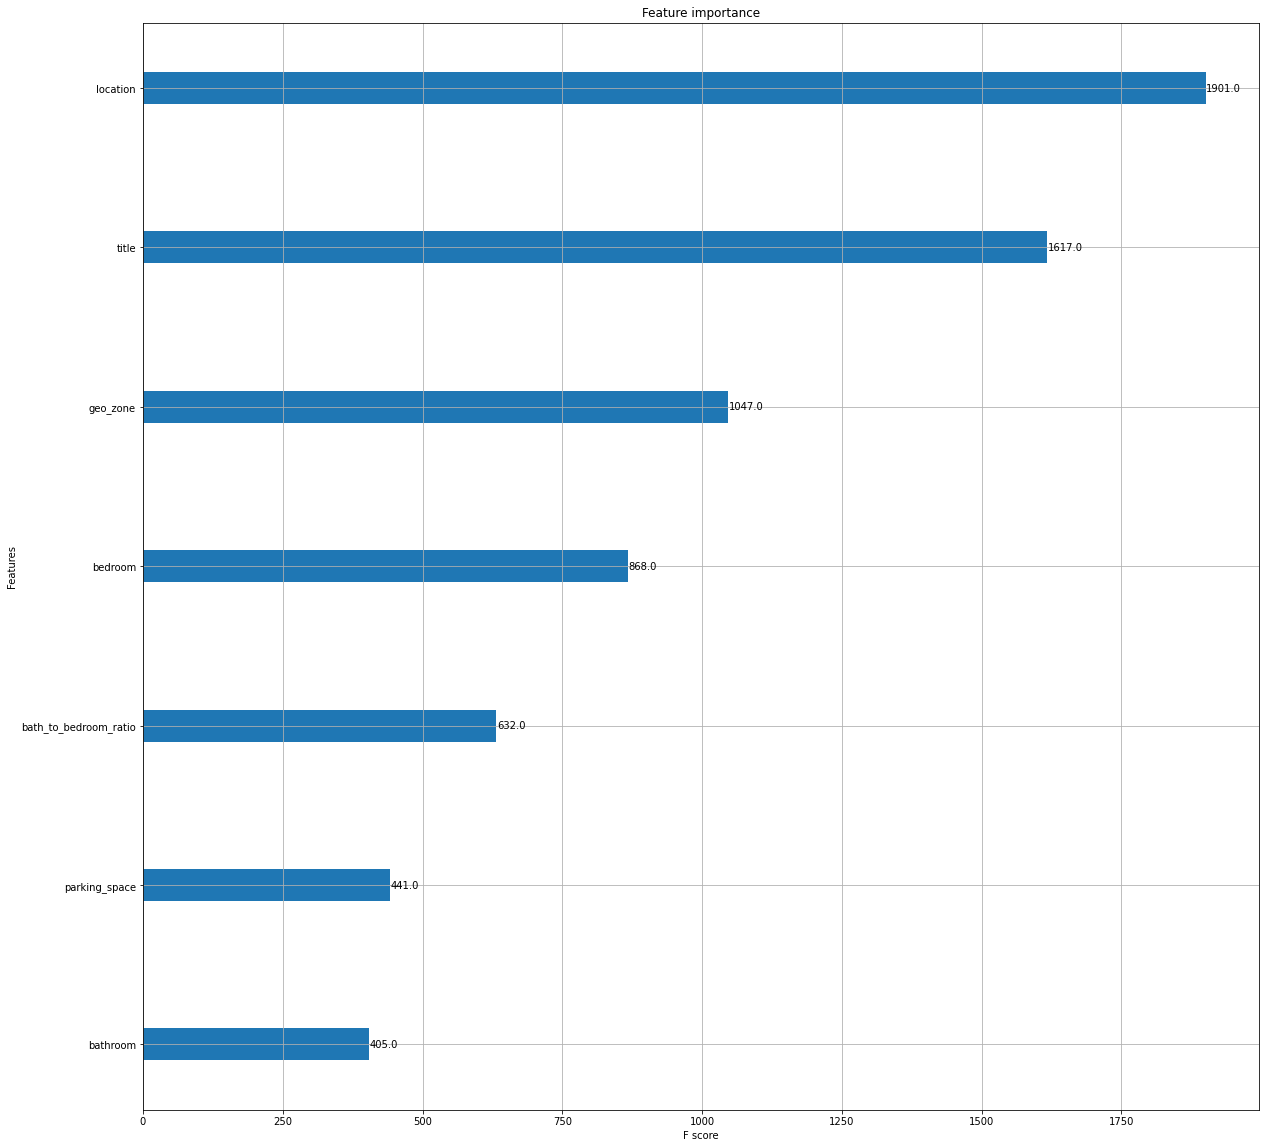

In [25]:
ax = plot_importance(xgb_model)

fig = ax.figure
fig.set_size_inches(20, 20)
ax.autoscale(enable=True) 

# title = 707
# location > 900

<br/><br/><br/>
# Using the model to make prediction on the new data

In [26]:
train_new = pd.read_csv("datasets/Housing_dataset_test.csv")
print(train.info())
print("\n First 5 data: \n")
print(train_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB
None

 First 5 data: 

      ID      loc                 title  bedroom  bathroom  parking_space
0    845     Kano             Penthouse        4         1              2
1   1924  Adamawa             Apartment        2         2              4
2  10718  Adamawa              Bungalow        2         7              2
3  12076    Lagos               Mansion        9         5              2
4  12254    Gombe  Semi-detached duplex

There are no null values in the new data we want to predict its prices so we can proceed without worrying about fixing null data

## Preparing the new data for  the model

In [27]:
sub = train_new.rename(columns={'loc': 'location'})

X_new = sub.drop('ID', axis=1)
print(X_new)

     location                 title  bedroom  bathroom  parking_space
0        Kano             Penthouse        4         1              2
1     Adamawa             Apartment        2         2              4
2     Adamawa              Bungalow        2         7              2
3       Lagos               Mansion        9         5              2
4       Gombe  Semi-detached duplex        5         6              1
...       ...                   ...      ...       ...            ...
5995    Ekiti                  Flat        4         5              2
5996  Adamawa        Terrace duplex        5         7              1
5997      Oyo             Townhouse        4         1              4
5998   Bauchi                  Flat        3         7              5
5999   Sokoto               Mansion        6         1              6

[6000 rows x 5 columns]


In [28]:
X_new = engineer_data(X_new)

X_new

   location  title  bedroom  bathroom  parking_space  geo_zone  \
0  0.028333      8        4         1              2  0.194000   
1  0.029167      9        2         2              4  0.170333   
2  0.029167      2        2         7              2  0.170333   
3  0.029000     10        9         5              2  0.174500   
4  0.026333      6        5         6              1  0.170333   

   bath_to_bedroom_ratio  
0               0.250000  
1               1.000000  
2               3.500000  
3               0.555556  
4               1.200000  


,location,title,bedroom,bathroom,parking_space,geo_zone,bath_to_bedroom_ratio
0,0.028333,8,4,1,2,0.194000,0.250000
1,0.029167,9,2,2,4,0.170333,1.000000
2,0.029167,2,2,7,2,0.170333,3.500000
3,0.029000,10,9,5,2,0.174500,0.555556
4,0.026333,6,5,6,1,0.170333,1.200000
...,...,...,...,...,...,...,...
5995,0.028333,7,4,5,2,0.174500,1.250000
5996,0.029167,4,5,7,1,0.170333,1.400000
5997,0.030500,3,4,1,4,0.174500,0.250000
5998,0.029167,7,3,7,5,0.170333,2.333333


In [29]:
X_new

,location,title,bedroom,bathroom,parking_space,geo_zone,bath_to_bedroom_ratio
0,0.028333,8,4,1,2,0.194000,0.250000
1,0.029167,9,2,2,4,0.170333,1.000000
2,0.029167,2,2,7,2,0.170333,3.500000
3,0.029000,10,9,5,2,0.174500,0.555556
4,0.026333,6,5,6,1,0.170333,1.200000
...,...,...,...,...,...,...,...
5995,0.028333,7,4,5,2,0.174500,1.250000
5996,0.029167,4,5,7,1,0.170333,1.400000
5997,0.030500,3,4,1,4,0.174500,0.250000
5998,0.029167,7,3,7,5,0.170333,2.333333


In [30]:
predictions = xgb_model.predict(X_new)
print(len(predictions))
print(len)
predictions

6000
<built-in function len>


array([14.281036 , 14.191839 , 14.299465 , ..., 14.5492525, 14.475783 ,
       14.942467 ], dtype=float32)

## Export my results as a csv file

In [31]:
predictions_train = pd.DataFrame(np.expm1(predictions), index=train_new.index, columns=['Predicted House Price'])
train_with_predictions = pd.concat([train_new, predictions_train], axis=1)
print(train_with_predictions)

         ID      loc                 title  bedroom  bathroom  parking_space  \
0       845     Kano             Penthouse        4         1              2   
1      1924  Adamawa             Apartment        2         2              4   
2     10718  Adamawa              Bungalow        2         7              2   
3     12076    Lagos               Mansion        9         5              2   
4     12254    Gombe  Semi-detached duplex        5         6              1   
...     ...      ...                   ...      ...       ...            ...   
5995   1594    Ekiti                  Flat        4         5              2   
5996   2416  Adamawa        Terrace duplex        5         7              1   
5997  10195      Oyo             Townhouse        4         1              4   
5998   9455   Bauchi                  Flat        3         7              5   
5999  11736   Sokoto               Mansion        6         1              6   

      Predicted House Price  
0        

In [32]:
train_with_predictions.to_csv('datasets/sub1.csv', encoding='utf-8', index=False)